In [45]:
import pandas as pd
import numpy as np

import requests
from pandas import DataFrame
from io import StringIO
import time, json
from datetime import date
import statsmodels
from statsmodels.tsa.stattools import adfuller, acf, pacf
import statsmodels.tsa.stattools as st
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
import pyflux as pf
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing

import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 18,9

def parser(time_data):
    return pd.datetime.strptime('2017-'+time_data,'%Y-%d-%m %H:%M:%S')
data = pd.read_csv('../data/namenode_1130-1212.csv',header=0,index_col=0, parse_dates=[0], date_parser=parser)

data = data.rename(columns={'cpu process':'top_cpu','memory process':'top_mem'})
data['top_cpu'] = data['top_cpu'].str.partition('/')[0]
data['top_mem'] = data['top_mem'].str.partition('/')[0]

buff_data = data['buff'].copy()
buff_data = buff_data.to_frame()
scaler = preprocessing.MinMaxScaler()
buff_data['norm'] = scaler.fit_transform(buff_data['buff'].values.reshape(-1,1))

In [38]:
def test_stationarity(timeseries):
    dftest = adfuller(timeseries, autolag='AIC')
    return dftest[1]


def best_diff(df,col='norm', maxdiff = 10):
    p_set = {}
    for i in range(0, maxdiff):
        temp = df.copy() #每次循环前，重置
        if i == 0:
            temp['diff'] = temp[col]
        else:
            temp['diff'] = temp[col].diff(i)
            temp = temp.drop(temp.iloc[:i].index) #差分后，前几行的数据会变成nan，所以删掉
        pvalue = test_stationarity(temp['diff'])
        p_set[i] = pvalue
        p_df = pd.DataFrame.from_dict(p_set, orient="index")
        p_df.columns = ['p_value']
    i = 0
    while i < len(p_df):
        if p_df['p_value'][i]<0.01:
            bestdiff = i
            break
        i += 1
    return bestdiff


def produce_diffed_timeseries(df, diffn):
    if diffn != 0:
        df['diff'] = df['norm'].apply(lambda x:float(x)).diff(diffn)
    else:
        df['diff'] = df['norm'].apply(lambda x:float(x))
    df.dropna(inplace=True) #差分之后的nan去掉
    return df


def choose_order(ts, maxar, maxma):
    order = st.arma_order_select_ic(ts, maxar, maxma, ic=['aic', 'bic', 'hqic'])
    return order.bic_min_order


def predict_recover(ts, df, diffn):
    if diffn != 0:
        ts.iloc[0] = ts.iloc[0]+df['norm'][-diffn]
        ts = ts.cumsum()
#     ts = np.exp(ts)
   ts.dropna(inplace=True)
    print('还原完成')
    return ts


def run_aram(df, col, maxar, maxma, test_size = 0.7):
    data = df
    train_size = int(len(data)*test_size)
    train, test = data[:train_size], data[train_size:]
    if test_stationarity(train[col]) < 0.01:
        print('平稳，不需要差分')
    else:
        diffn = best_diff(train)
        train = produce_diffed_timeseries(train, diffn)
        print('差分阶数为'+str(diffn)+'，已完成差分')
    print('开始进行ARMA拟合')
    order = choose_order(train['diff'], maxar, maxma)
    print('模型的阶数为：'+str(order))
    _ar = order[0]
    _ma = order[1]
#     _ar = 2
#     _ma = 4
    model = pf.ARIMA(data=train, ar=_ar, ma=_ma, target='diff', family=pf.Normal())
    model.fit("MLE")
    print('fit finished')
    test_predict = model.predict(int(test_size))
    print('predict finished')    
    test_predict = predict_recover(test_predict, train, diffn)
    test['predict'] = test_predict
    RMSE = np.sqrt(((np.array(test_predict)-np.array(test))**2).sum()/test.size)
    print("测试集的RMSE为："+str(RMSE))
    test['norm'].plot()
    test['predict'].plot()
    plt.show()

In [40]:
    data = buff_data
    col = 'norm'
    maxar , maxma = 5,5
    train_size = int(len(data)*test_size)
    train, test = data[:train_size], data[train_size:]
    if test_stationarity(train[col]) < 0.01:
        print('平稳，不需要差分')
    else:
        diffn = best_diff(train)
        train = produce_diffed_timeseries(train, diffn)
        print('差分阶数为'+str(diffn)+'，已完成差分')
    print('开始进行ARMA拟合')
    order = choose_order(train['diff'], maxar, maxma)
    print('模型的阶数为：'+str(order))
    _ar = order[0]
    _ma = order[1]
#     _ar = 2
#     _ma = 4
    model = pf.ARIMA(data=train, ar=_ar, ma=_ma, target='diff', family=pf.Normal())
    model.fit("M-H")
    model.plot_fit()
    print('fit finished')
    test_predict = model.predict(int(test_size))
    print('predict finished')    
    test_predict = predict_recover(test_predict, train, diffn)
    test['predict'] = test_predict

差分阶数为1，已完成差分
开始进行ARMA拟合
模型的阶数为：(0, 2)


fit finished
predict finished
还原完成


In [57]:
model = pf.ARIMA(data=train, ar=0, ma=2, target='diff', family=pf.Normal())
# modeled.summary()
model.fit('M-H')

Acceptance rate of Metropolis-Hastings is 0.17005
Acceptance rate of Metropolis-Hastings is 0.26635

Tuning complete! Now sampling.
Acceptance rate of Metropolis-Hastings is 0.2587


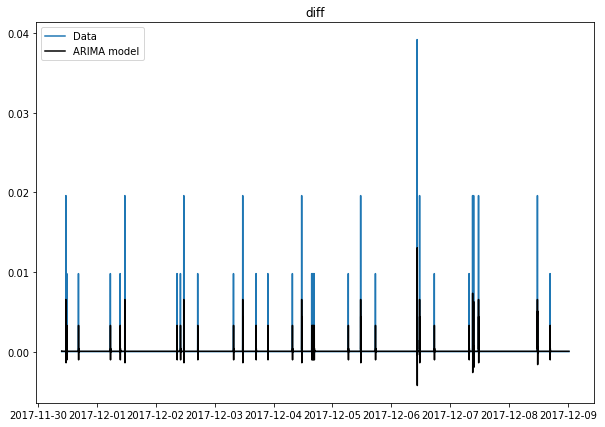

,diff
date/time,
2017-12-09 00:18:40,0.000039
2017-12-09 00:19:40,0.000044
2017-12-09 00:20:40,0.000047
2017-12-09 00:21:39,0.000061
2017-12-09 00:22:40,0.000053


In [61]:
model.plot_fit()


In [1]:
model.predict(5)

NameError: name 'model' is not defined